# Machine Learning

As with the previous section, we'll look at some, but not all, popular machine learning packages in Julia. This part of the ecosystem is under heavy active development currently and could use more full-Julia options.

In [1]:
using GaussianProcesses
import Random

Random.seed!(20140430)
# Training data
n=10;                          #number of training points
x = 2π * rand(n);              #predictors
y = sin.(x) + 0.05*randn(n);   #regressors

In [2]:
#Select mean and covariance function
mZero = MeanZero()                   #Zero mean function
kern = SE(0.0,0.0)                   #Sqaured exponential kernel (note that hyperparameters are on the log scale)

logObsNoise = -1.0                        # log standard deviation of observation noise (this is optional)
gp = GP(x,y,mZero,kern,logObsNoise)       #Fit the GP

GP Exact object:
  Dim = 1
  Number of observations = 10
  Mean function:
    Type: MeanZero, Params: Float64[]
  Kernel:
    Type: SEIso{Float64}, Params: [0.0, 0.0]
  Input observations = 
[4.854610892030431 5.176527683588912 … 1.9941157865846477 3.4567590405289352]
  Output observations = [-0.9672931901680022, -1.0070469610508248, -1.0903962829715461, 0.8811208605233783, -0.3332131916909575, -0.9769651482106089, 0.9159341732111771, 0.7362180710829012, 0.9508490881368652, -0.3064317818816142]
  Variance of observation noise = 0.1353352832366127
  Marginal Log-Likelihood = -6.335

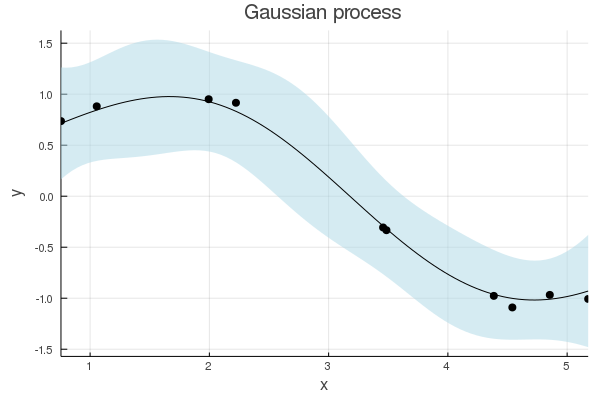

In [3]:
import Plots

Plots.plot(gp; xlabel="x", ylabel="y", title="Gaussian process", legend=false, fmt=:png)

In [4]:
using Optim
rosenbrock(x) =  (1.0 - x[1])^2 + 100.0 * (x[2] - x[1]^2)^2
result = optimize(rosenbrock, zeros(2), BFGS())

 * Status: success

 * Candidate solution
    Minimizer: [1.00e+00, 1.00e+00]
    Minimum:   5.471433e-17

 * Found with
    Algorithm:     BFGS
    Initial Point: [0.00e+00, 0.00e+00]

 * Convergence measures
    |x - x'|               = 3.47e-07 ≰ 0.0e+00
    |x - x'|/|x'|          = 3.47e-07 ≰ 0.0e+00
    |f(x) - f(x')|         = 6.59e-14 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 1.20e+03 ≰ 0.0e+00
    |g(x)|                 = 2.33e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   1  (vs limit Inf)
    Iterations:    16
    f(x) calls:    53
    ∇f(x) calls:   53


In [5]:
optimize!(gp; method=ConjugateGradient())

 * Status: success

 * Candidate solution
    Minimizer: [-2.99e+00, 4.64e-01, -2.29e-01]
    Minimum:   -3.275745e+00

 * Found with
    Algorithm:     Conjugate Gradient
    Initial Point: [-1.00e+00, 0.00e+00, 0.00e+00]

 * Convergence measures
    |x - x'|               = 2.12e-09 ≰ 0.0e+00
    |x - x'|/|x'|          = 7.08e-10 ≰ 0.0e+00
    |f(x) - f(x')|         = 1.42e-14 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 4.34e-15 ≰ 0.0e+00
    |g(x)|                 = 3.80e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    26
    f(x) calls:    64
    ∇f(x) calls:   40


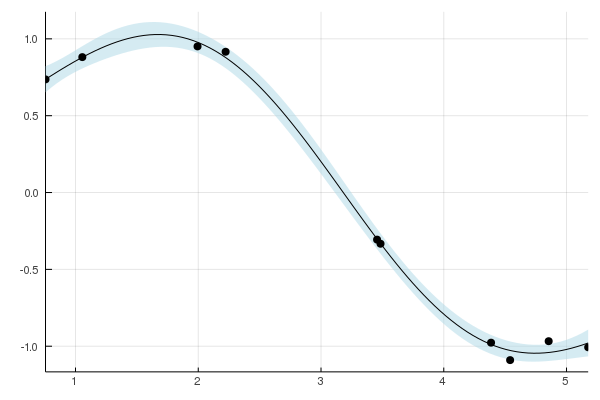

In [6]:
Plots.plot(gp; legend=false, fmt=:png)

## DecisionTree.jl

Provides Decision Trees and Random Forests, with a scikit-learn based API

In [7]:
using DecisionTree

In [8]:
using DataFrames, RDatasets
iris = dataset("datasets", "iris");
features = convert(Array, iris[:, 1:4])
labels = string.(iris[!, :Species])
features, labels

([5.1 3.5 1.4 0.2; 4.9 3.0 1.4 0.2; … ; 6.2 3.4 5.4 2.3; 5.9 3.0 5.1 1.8], ["setosa", "setosa", "setosa", "setosa", "setosa", "setosa", "setosa", "setosa", "setosa", "setosa"  …  "virginica", "virginica", "virginica", "virginica", "virginica", "virginica", "virginica", "virginica", "virginica", "virginica"])

In [9]:
model = DecisionTreeClassifier(max_depth=2)

DecisionTreeClassifier
max_depth:                2
min_samples_leaf:         1
min_samples_split:        2
min_purity_increase:      0.0
pruning_purity_threshold: 1.0
n_subfeatures:            0
classes:                  nothing
root:                     nothing

In [10]:
DecisionTree.fit!(model, features, labels)
print_tree(model)

Feature 3, Threshold 2.45
L-> setosa : 50/50
R-> Feature 4, Threshold 1.75
    L-> versicolor : 49/54
    R-> virginica : 45/46


In [11]:
y = DecisionTree.predict(model, features);
sum(y .!= iris[!, :Species])

6

┌ Info: Loading DataFrames support into Gadfly.jl
└ @ Gadfly /home/d9w/.julia/packages/Gadfly/09PWZ/src/mapping.jl:228
┌ Warning: `getindex(df::DataFrame, col_ind::ColumnIndex)` is deprecated, use `df[!, col_ind]` instead.
│   caller = evalmapping at dataframes.jl:96 [inlined]
└ @ Core /home/d9w/.julia/packages/Gadfly/09PWZ/src/dataframes.jl:96


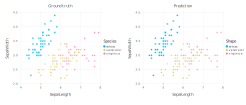

In [12]:
using Gadfly
p1 = plot(iris, x="SepalLength", y="SepalWidth", color="Species", shape="Species", Geom.point, 
    Guide.title("Ground truth"));
p2 = plot(iris, x="SepalLength", y="SepalWidth", color=y, shape=y, Geom.point, Guide.title("Prediction"));
set_default_plot_size(700pt, 300pt)
hstack(p1, p2)

# ScikitLearn.jl

Uses PyCall to adapt the ScikitLearn library to Julia and adds interaction with existing Julia libraries, like GaussianProcesses.jl and DecisionTrees.jl

In [13]:
using ScikitLearn
@sk_import linear_model: LogisticRegression
model = LogisticRegression(fit_intercept=true)

PyObject LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [14]:
X = convert(Array, iris[!, [:SepalLength, :SepalWidth, :PetalLength, :PetalWidth]])
y = convert(Array, iris[!, :Species])
fit!(model, X, y)

accuracy = sum(ScikitLearn.predict(model, X) .== y) / length(y)
println("accuracy: $accuracy")

accuracy: 0.9733333333333334


# Flux.jl

A general machine learning library with a focus on deep learning, entirely in Julia

In [15]:
using Flux, Statistics
using Flux: onehotbatch, onecold, crossentropy, throttle
using Base.Iterators: repeated
using Flux.Data.FashionMNIST

┌ Info: CUDAdrv.jl failed to initialize, GPU functionality unavailable (set JULIA_CUDA_SILENT or JULIA_CUDA_VERBOSE to silence or expand this message)
└ @ CUDAdrv /home/d9w/.julia/packages/CUDAdrv/mCr0O/src/CUDAdrv.jl:69


In [16]:
train_imgs = FashionMNIST.images(:train)
train_labels = FashionMNIST.labels(:train)
text_labels = ["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat", "Sandal",
    "Shirt", "Sneaker", "Bag", "Ankle boot"];

In [17]:
println(text_labels[train_labels[1]+1])
train_imgs[1]

Ankle boot


In [18]:
batch_size = 128

X = hcat(float.(reshape.(train_imgs, :))...)
Y = onehotbatch(train_labels, 0:9)
batches=[(X[:,i],Y[:,i]) for i in Iterators.partition(1:length(train_imgs),batch_size)];

In [19]:
SimpleNet = Chain(
            Dense(28^2,120),
            Dense(120,10),softmax)

Chain(Dense(784, 120), Dense(120, 10), softmax)

In [20]:
loss(x,y) = crossentropy(SimpleNet(x),y)
opt = Descent()

nn_accuracy(x, y) = mean(onecold(cpu(SimpleNet(x))) .== onecold(cpu(y)))
evalcb = throttle(()->println(nn_accuracy(X,Y)), 1);

In [21]:
Flux.train!(loss, params(SimpleNet), batches, opt, cb = evalcb)

0.1498
0.7043
0.7396333333333334
0.7269833333333333
0.7887666666666666
0.79895
0.80735
0.8014166666666667
0.8012666666666667
0.8209166666666666
0.8253
0.8227833333333333
0.8195
0.8290833333333333
0.8320166666666666
0.82685
0.8155
0.79055


In [22]:
test_imgs = FashionMNIST.images(:test)
predictions = onecold(SimpleNet(hcat(float.(reshape.(test_imgs, :))...)))
test_labels = FashionMNIST.labels(:test) .+ 1;

In [23]:
sum(predictions .== test_labels) / length(test_labels)

0.8236

In [24]:
wrong = predictions .!= test_labels
println("Prediction\tReal Label")
for i in findall(wrong)[1:5]
    println(text_labels[predictions[i]], "\t\t",
        text_labels[test_labels[i]])
end

Prediction	Real Label
Sandal		Sneaker
T-shirt/top		Pullover
Sneaker		Sandal
Sneaker		Ankle boot
Pullover		Coat


In [25]:
test_imgs[findfirst(wrong)]